In the name of Allah

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

### preprocessing data

In [2]:
!cp /content/drive/MyDrive/MLSD/hw1/data/feature_eng/ex2_none_data.csv /content/

In [3]:
df = pd.read_csv("/content/ex2_none_data.csv")
df

,cat1,cat2,cat3,0,1,2,3,4,5,6,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,2376
0,electronic-devices,computers,laptop-notebook-macbook,-0.187321,-0.160197,-0.446723,-0.610530,-0.667940,0.129657,0.729356,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
1,electronic-devices,computers,laptop-notebook-macbook,-0.266545,0.106528,-0.306745,-0.453215,-0.671516,0.438867,0.797655,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0
2,electronic-devices,computers,laptop-notebook-macbook,-0.431692,0.111641,-0.230805,0.013234,-0.474416,0.371503,0.803228,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
3,electronic-devices,computers,laptop-notebook-macbook,0.394037,0.036261,-0.154051,-0.362726,-0.222914,0.177530,0.479490,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,electronic-devices,computers,laptop-notebook-macbook,-0.545269,0.106218,-0.279060,0.155012,-0.545035,0.226797,0.786807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,vehicles,auto,car,0.149642,0.073088,-0.156852,-0.642408,-0.221737,0.447867,0.284083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0
1424,vehicles,auto,car,-0.267933,0.232681,0.065061,0.110129,0.512283,0.702256,0.419890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0
1425,vehicles,auto,car,-0.147635,0.287267,0.000560,-0.170773,-0.277191,0.466869,0.696770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0
1426,vehicles,auto,car,-0.517652,0.086050,0.295634,-0.267557,0.366268,0.405394,0.694922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0


In [4]:
X_df = df[[f'{i}' for i in range(2377)]]
X_df

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,2376
0,-0.187321,-0.160197,-0.446723,-0.610530,-0.667940,0.129657,0.729356,-0.549385,-0.590004,-0.848624,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
1,-0.266545,0.106528,-0.306745,-0.453215,-0.671516,0.438867,0.797655,-0.258158,-0.678108,0.040787,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0
2,-0.431692,0.111641,-0.230805,0.013234,-0.474416,0.371503,0.803228,0.136057,-0.693829,-0.891467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
3,0.394037,0.036261,-0.154051,-0.362726,-0.222914,0.177530,0.479490,-0.583333,-0.694722,-0.208147,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,-0.545269,0.106218,-0.279060,0.155012,-0.545035,0.226797,0.786807,-0.509011,-0.879691,-0.758809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,0.149642,0.073088,-0.156852,-0.642408,-0.221737,0.447867,0.284083,-0.279820,-0.865966,-0.804095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0
1424,-0.267933,0.232681,0.065061,0.110129,0.512283,0.702256,0.419890,-0.579341,-0.811541,-0.765304,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0
1425,-0.147635,0.287267,0.000560,-0.170773,-0.277191,0.466869,0.696770,-0.690475,-0.563626,-0.721483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0
1426,-0.517652,0.086050,0.295634,-0.267557,0.366268,0.405394,0.694922,-0.130498,-0.882596,-0.664231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0


In [5]:
y_df = {}
cat1_2_id = {t:i for i, t in enumerate(list(np.unique(df['cat1'])))}
cat2_2_id = {t:i for i, t in enumerate(list(np.unique(df['cat2'])))}
cat3_2_id = {t:i for i, t in enumerate(list(np.unique(df['cat3'])))}
y_df['cat1'] = [cat1_2_id[t] for t in df['cat1']]
y_df['cat2'] = [cat2_2_id[t] for t in df['cat2']]
y_df['cat3'] = [cat3_2_id[t] for t in df['cat3']]
y_df = pd.DataFrame(y_df)
y_df

,cat1,cat2,cat3
0,0,4,6
1,0,4,6
2,0,4,6
3,0,4,6
4,0,4,6
...,...,...,...
1423,3,1,5
1424,3,1,5
1425,3,1,5
1426,3,1,5


### Split train, val, test

In [6]:
X = {'train': None, 'test': None, 'val': None}
y = {'train': None, 'test': None, 'val': None}

X_trainval, X['test'], y_trainval, y['test'] = train_test_split(X_df, y_df, 
                                                                test_size=0.2, 
                                                                stratify=y_df, 
                                                                shuffle=True, 
                                                                random_state=69)

X['train'], X['val'], y['train'], y['val'] = train_test_split(X_trainval, 
                                                              y_trainval,
                                                              test_size=0.1, 
                                                              stratify=y_trainval, 
                                                              shuffle=True, 
                                                              random_state=21)



scaler = MinMaxScaler()
X['train'] = scaler.fit_transform(X['train'])
X['val'] = scaler.transform(X['val'])
X['test'] = scaler.transform(X['test'])
X['train'], y['train'] = np.array(X['train']).astype('float32'), np.array(y['train'])
X['val'], y['val'] = np.array(X['val']).astype('float32'), np.array(y['val'])
X['test'], y['test'] = np.array(X['test']).astype('float32'), np.array(y['test'])

### Create dataset and dataloaders

In [7]:
class Data(Dataset):
    def __init__(self, x_train, y_train):
        self.x = x_train
        self.y = y_train
        self.len = self.x.shape[0]

    def __getitem__(self,index):      
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

Set hyper-parameter:

- batch-size: 256
- weighted-loss: True

In [8]:
batch_size = 256
weighted_loss = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataloaders = {}
dataset_sizes = {}

for phase in ['train', 'val', 'test']:
    data_set = Data(X[phase], y[phase])
    dataset_sizes[phase] = data_set.len
    dataloaders[phase] = DataLoader(dataset=data_set, batch_size=batch_size)

### Define Model

In [9]:
class MyClassifier(nn.Module):
    def __init__(self, in_dim, out1_dim, out2_dim, out3_dim):
        super(MyClassifier, self).__init__()
        self.in_layer = nn.Linear(in_dim, 4096)
        self.bn0 = nn.BatchNorm1d(4096)
        self.hidden1_layer = nn.Linear(4096, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.hidden2_layer = nn.Linear(1024, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.hidden3_layer = nn.Linear(256, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.hidden4_layer = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.out1_layer = nn.Linear(32, out1_dim)
        self.out2_layer = nn.Linear(32+out1_dim, out2_dim)
        self.out3_layer = nn.Linear(32+out1_dim+out2_dim, out3_dim)
        self.soft_max = nn.Softmax(dim=1)
    

    def forward(self,x):
        x = self.in_layer(x)
        x = self.bn0(x)
        x = torch.relu(x)

        x = self.hidden1_layer(x)
        x = self.bn1(x)
        x = torch.relu(x)

        x = self.hidden2_layer(x)
        x = self.bn2(x)
        x = torch.relu(x)

        x = self.hidden3_layer(x)
        x = self.bn3(x)
        x = torch.relu(x)

        x = self.hidden4_layer(x)
        x = self.bn4(x)
        x = torch.relu(x)

        out1 = self.out1_layer(x)

        out2 = torch.cat([x, out1], dim=1)
        out2 = self.out2_layer(out2)

        out3 = torch.cat([x, out1, out2], dim=1)
        out3 = self.out3_layer(out3)

        out1 = self.soft_max(out1)
        out2 = self.soft_max(out2)
        out3 = self.soft_max(out3)

        return out1, out2, out3

### Define Loss

In [10]:
criterion = [None, None, None]

if weighted_loss:
    class_weights = [None]*3
    for i in range(3):
        class_weights[i] = compute_class_weight(class_weight = "balanced", 
                                                classes = np.unique(np.array(y['train'])[:,i]), 
                                                y = np.array(y['train'])[:,i])
        class_weights[i] = torch.tensor(class_weights[i], dtype=torch.float)
        criterion[i] = nn.CrossEntropyLoss(weight=class_weights[i])
else:
    criterion[0] = nn.CrossEntropyLoss()
    criterion[1] = nn.CrossEntropyLoss()
    criterion[2] = nn.CrossEntropyLoss()

### Load model and set optimizer to Adam

Set hyper-parameter:

- a, b, c: 1, 2, 7 (Cost function coefficients for different categories)

In [14]:
model = MyClassifier(in_dim=X['train'].shape[1], 
                     out1_dim=len(np.unique(y_df['cat1'])), 
                     out2_dim=len(np.unique(y_df['cat2'])), 
                     out3_dim=len(np.unique(y_df['cat3']))
                     )

model = model.to(device)

learning_rate = 2e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

a = 1
b = 2
c = 5

### Define train function

In [15]:
def train_model(model, criterion, optimizer, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = [100, 100, 100]
    loss_history = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = [0,0,0]

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = [None, None, None]
                    for i in range(3):
                        loss[i] = criterion[i](outputs[i], labels[:,i])
                        running_loss[i] += loss[i].item()
                    total_loss = a*loss[0] + b*loss[1] + c*loss[2]

                    if phase == 'train':
                        total_loss.backward()
                        optimizer.step()

            for i in range(3):
                running_loss[i] = running_loss[i]/dataset_sizes[phase]
                print(f'{phase} Loss[cat{i}]: {running_loss[i]:.6f}')
            
            loss_history[phase].append(running_loss)

            # deep copy the model
            diff = 1e-5
            if phase == 'val' and (running_loss[0]+diff < best_loss[0] or running_loss[1]+diff < best_loss[1] or running_loss[2]+diff < best_loss[2]):
                best_loss = running_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                print('** Model Saved **')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history

### Train model

In [16]:
model, loss_history = train_model(model, criterion, optimizer, num_epochs=4000)

Streaming output truncated to the last 5000 lines.
train Loss[cat0]: 0.003685
train Loss[cat1]: 0.005687
train Loss[cat2]: 0.007118
val Loss[cat0]: 0.008448
val Loss[cat1]: 0.012618
val Loss[cat2]: 0.015856

Epoch 3453/4000
----------
train Loss[cat0]: 0.003685
train Loss[cat1]: 0.005687
train Loss[cat2]: 0.007118
val Loss[cat0]: 0.008449
val Loss[cat1]: 0.012618
val Loss[cat2]: 0.015849

Epoch 3454/4000
----------
train Loss[cat0]: 0.003685
train Loss[cat1]: 0.005687
train Loss[cat2]: 0.007118
val Loss[cat0]: 0.008447
val Loss[cat1]: 0.012617
val Loss[cat2]: 0.015855

Epoch 3455/4000
----------
train Loss[cat0]: 0.003684
train Loss[cat1]: 0.005687
train Loss[cat2]: 0.007118
val Loss[cat0]: 0.008446
val Loss[cat1]: 0.012617
val Loss[cat2]: 0.015846

Epoch 3456/4000
----------
train Loss[cat0]: 0.003685
train Loss[cat1]: 0.005687
train Loss[cat2]: 0.007118
val Loss[cat0]: 0.008446
val Loss[cat1]: 0.012616
val Loss[cat2]: 0.015853

Epoch 3457/4000
----------
train Loss[cat0]: 0.003684
tr

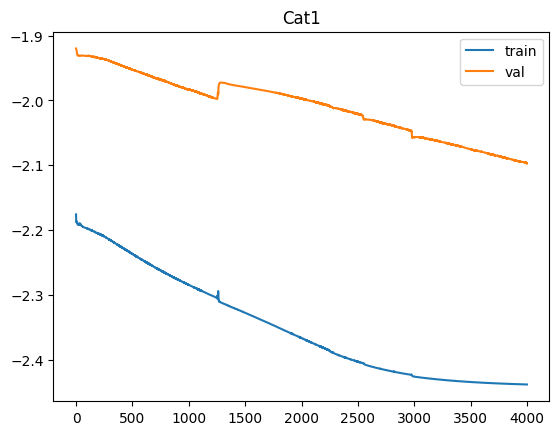

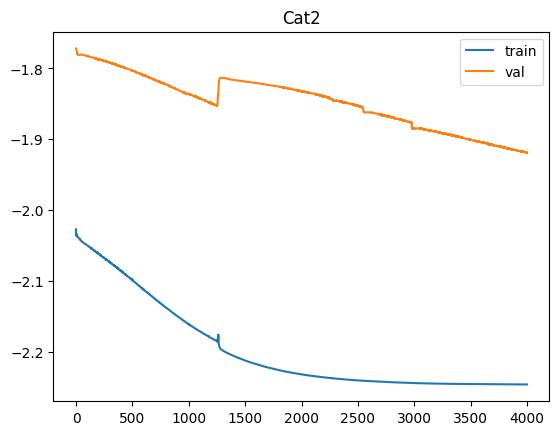

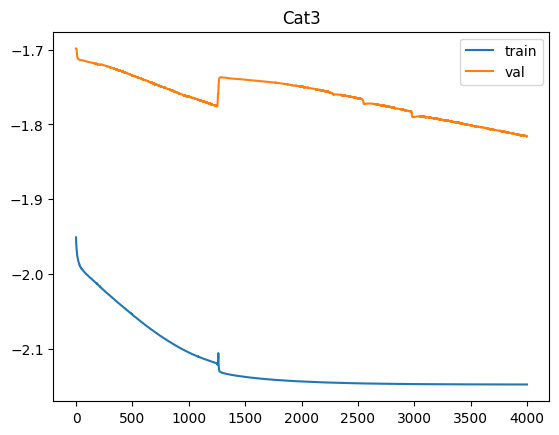

In [17]:
def plot_loss_history(title, index, loss_history):
    loss_cat_train = [l[index] for l in np.log10(loss_history['train'])]
    loss_cat_val = [l[index] for l in np.log10(loss_history['val'])]
    plt.plot(loss_cat_train, label="train")
    plt.plot(loss_cat_val, label="val")
    plt.title(title)
    plt.legend()
    plt.show()

plot_loss_history("Cat1", 0, loss_history)
plot_loss_history("Cat2", 1, loss_history)
plot_loss_history("Cat3", 2, loss_history)

### Testing the model

In [18]:
model.eval()

MyClassifier(
  (in_layer): Linear(in_features=2377, out_features=4096, bias=True)
  (bn0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden1_layer): Linear(in_features=4096, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden2_layer): Linear(in_features=1024, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden3_layer): Linear(in_features=256, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden4_layer): Linear(in_features=64, out_features=32, bias=True)
  (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out1_layer): Linear(in_features=32, out_features=4, bias=True)
  (out2_layer): Linear(in_features=36, out_features=7, bias=True)
  (out3_layer): Linear(in_features=43, out_feat

#### Calculate Loss

In [20]:
test_loss = [0,0,0]
for inputs, labels in dataloaders['test']:
    with torch.no_grad():
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = [None, None, None]
        for i in range(3):
            loss[i] = criterion[i](outputs[i], labels[:,i])
            test_loss[i] += loss[i].item()
for i in range(3):
    test_loss[i] = test_loss[i]/dataset_sizes['test']
for i in range(3):
    print(f'Test Loss[cat{i}]: {test_loss[i]:.6f}')

Test Loss[cat0]: 0.006491
Test Loss[cat1]: 0.009837
Test Loss[cat2]: 0.012084


#### Define a function to use the model directly

In [22]:
def get_cat(x):
    model.eval()
    with torch.no_grad():
        x = x.to(device)
        p1, p2, p3 = model(x)
        _, out1 = torch.max(p1, dim = 1)
        _, out2 = torch.max(p2, dim = 1)
        _, out3 = torch.max(p3, dim = 1)
    return out1, out2, out3

#### Calculate Accuracy

In [24]:
y_true = []
y_pred = []
for inputs, labels in dataloaders['test']:
    outputs = get_cat(inputs)
    outputs = [outputs[0].cpu().detach().numpy(), 
               outputs[1].cpu().detach().numpy(), 
               outputs[2].cpu().detach().numpy()]
    outputs = [[o1, o2, o3] for o1, o2, o3 in zip(outputs[0], outputs[1], outputs[2])]
    y_true.extend(labels.cpu().detach().numpy())
    y_pred.extend(outputs)

In [25]:
def accuracy(pred, true):
    true_count = [0,0,0]
    for p,t in zip(pred, true):
        for i in range(3):
            if p[i] == t[i]:
                true_count[i] += 1
    true_count = np.divide(true_count,len(pred))
    return true_count

In [26]:
acc = accuracy(pred=y_pred, true=y_true)
for i in range(3):
    print(f'Accuracy [cat{i+1}]: %{acc[i]*100:.2f}')

Accuracy [cat1]: %93.71
Accuracy [cat2]: %90.56
Accuracy [cat3]: %83.92


#### Some sample

In [28]:
for inputs, labels in dataloaders['test']:
    outputs = get_cat(inputs)
    break

outputs = [outputs[0].cpu().detach().numpy(),
           outputs[1].cpu().detach().numpy(),
           outputs[2].cpu().detach().numpy()]
outputs = [[o1, o2, o3] for o1, o2, o3 in zip(outputs[0], outputs[1], outputs[2])]
labels = labels.cpu().detach().numpy() 
for output, label in zip(outputs, labels):
    for i in range(3):
        print(f'[cat{i+1}] True: {label[i]} \t Pred: {output[i]} \t Eq: {output[i] == label[i]}')

[cat1] True: 1 	 Pred: 1 	 Eq: True
[cat2] True: 0 	 Pred: 0 	 Eq: True
[cat3] True: 8 	 Pred: 8 	 Eq: True
[cat1] True: 1 	 Pred: 1 	 Eq: True
[cat2] True: 0 	 Pred: 0 	 Eq: True
[cat3] True: 8 	 Pred: 8 	 Eq: True
[cat1] True: 1 	 Pred: 1 	 Eq: True
[cat2] True: 0 	 Pred: 0 	 Eq: True
[cat3] True: 9 	 Pred: 9 	 Eq: True
[cat1] True: 1 	 Pred: 1 	 Eq: True
[cat2] True: 0 	 Pred: 0 	 Eq: True
[cat3] True: 8 	 Pred: 8 	 Eq: True
[cat1] True: 1 	 Pred: 1 	 Eq: True
[cat2] True: 0 	 Pred: 0 	 Eq: True
[cat3] True: 8 	 Pred: 8 	 Eq: True
[cat1] True: 0 	 Pred: 0 	 Eq: True
[cat2] True: 5 	 Pred: 5 	 Eq: True
[cat3] True: 7 	 Pred: 7 	 Eq: True
[cat1] True: 0 	 Pred: 1 	 Eq: False
[cat2] True: 5 	 Pred: 3 	 Eq: False
[cat3] True: 7 	 Pred: 1 	 Eq: False
[cat1] True: 3 	 Pred: 3 	 Eq: True
[cat2] True: 1 	 Pred: 1 	 Eq: True
[cat3] True: 5 	 Pred: 5 	 Eq: True
[cat1] True: 0 	 Pred: 0 	 Eq: True
[cat2] True: 4 	 Pred: 4 	 Eq: True
[cat3] True: 6 	 Pred: 6 	 Eq: True
[cat1] True: 1 	 Pred: 1 